# Part 3 of 3

## Data Modeling and Policy Analysis

This notebook covers questions in section 2 and 3, and finally compiled in presentation slides. 

### Import and load data

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score,train_test_split, GridSearchCV
from sklearn import metrics 
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, recall_score, silhouette_score

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
resale_df = pd.read_csv('data/final_resale.csv')

In [3]:
print(resale_df.shape)
resale_df.head()

(882951, 20)


,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,storey_lower,storey_upper,block_num,storey_ave,remaining_lease,address,latitude,longitude,min_distance_to_mrt,min_distance_to_mall
0,1990-01-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976-01-01,47200.0,4,6,216,5.0,85,216 ANG MO KIO AVE 1,1.366197,103.841505,0.954205,0.804708
1,1990-01-01,ANG MO KIO,3 ROOM,211,ANG MO KIO AVE 3,01 TO 03,67.0,NEW GENERATION,1977-01-01,46000.0,1,3,211,2.0,86,211 ANG MO KIO AVE 3,1.369197,103.841667,0.867154,0.564789
2,1990-01-01,ANG MO KIO,3 ROOM,202,ANG MO KIO AVE 3,07 TO 09,67.0,NEW GENERATION,1977-01-01,42000.0,7,9,202,8.0,86,202 ANG MO KIO AVE 3,1.368458,103.844515,0.560137,0.416562
3,1990-01-01,ANG MO KIO,3 ROOM,235,ANG MO KIO AVE 3,10 TO 12,67.0,NEW GENERATION,1977-01-01,38000.0,10,12,235,11.0,86,235 ANG MO KIO AVE 3,1.366824,103.836491,1.471209,1.194848
4,1990-01-01,ANG MO KIO,3 ROOM,235,ANG MO KIO AVE 3,04 TO 06,67.0,NEW GENERATION,1977-01-01,40000.0,4,6,235,5.0,86,235 ANG MO KIO AVE 3,1.366824,103.836491,1.471209,1.194848


In [4]:
resale_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 882951 entries, 0 to 882950
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   month                 882951 non-null  object 
 1   town                  882951 non-null  object 
 2   flat_type             882951 non-null  object 
 3   block                 882951 non-null  object 
 4   street_name           882951 non-null  object 
 5   storey_range          882951 non-null  object 
 6   floor_area_sqm        882951 non-null  float64
 7   flat_model            882951 non-null  object 
 8   lease_commence_date   882951 non-null  object 
 9   resale_price          882951 non-null  float64
 10  storey_lower          882951 non-null  int64  
 11  storey_upper          882951 non-null  int64  
 12  block_num             882951 non-null  int64  
 13  storey_ave            882951 non-null  float64
 14  remaining_lease       882951 non-null  int64  
 15  

In [5]:
# change to time format for date columns
for x in ['month','lease_commence_date']:
    resale_df[x] = pd.to_datetime(resale_df[x].astype(str))

In [24]:
# filter list of numeric columns only
numerical_cols = resale_df.select_dtypes(include=['float', 'int']).columns.tolist()
numerical_cols

['floor_area_sqm',
 'resale_price',
 'storey_lower',
 'storey_upper',
 'block_num',
 'storey_ave',
 'remaining_lease',
 'latitude',
 'longitude',
 'min_distance_to_mrt',
 'min_distance_to_mall']

In [27]:
# only want the original numeric features for plotting
for x in ['latitude', 'longitude', 'min_distance_to_mrt', 'min_distance_to_mall']:
    numerical_cols.remove(x)

In [28]:
numerical_cols

['floor_area_sqm',
 'resale_price',
 'storey_lower',
 'storey_upper',
 'block_num',
 'storey_ave',
 'remaining_lease']

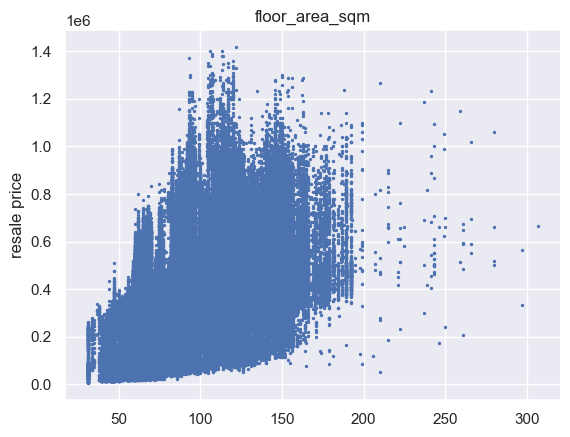

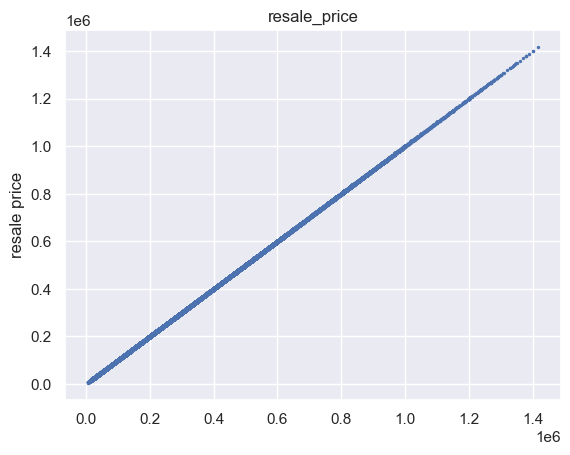

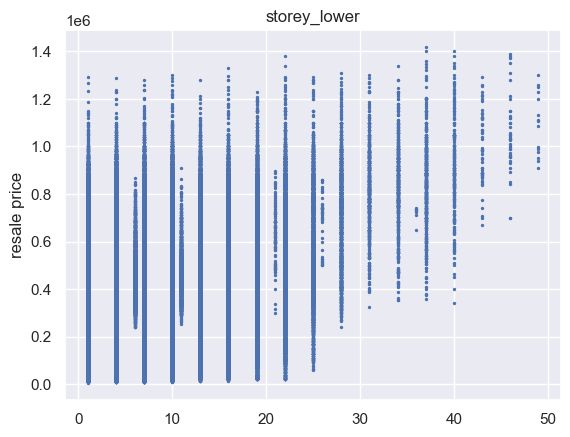

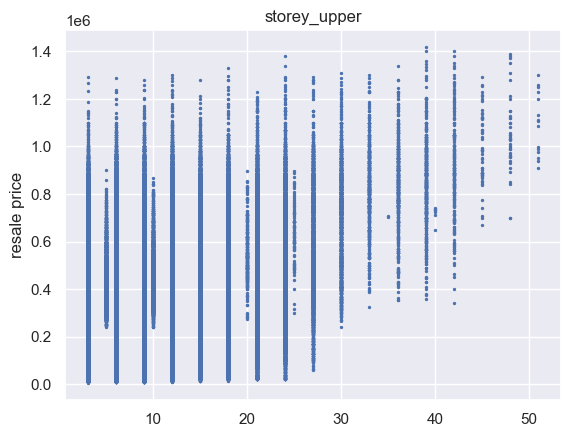

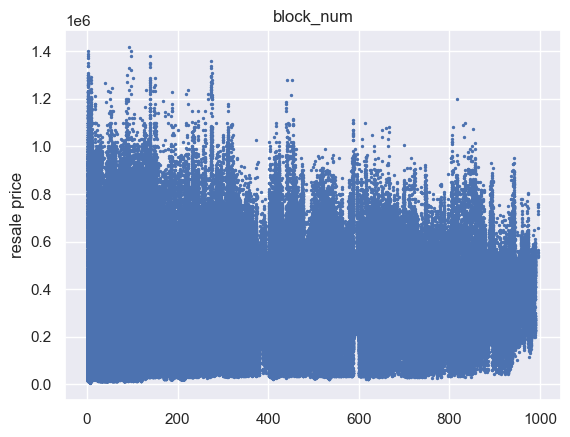

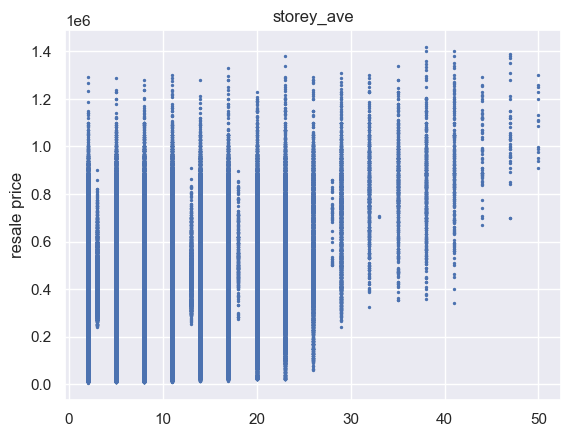

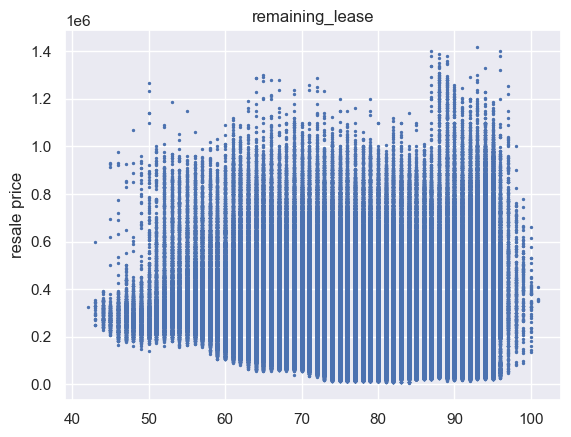

In [31]:
for col in numerical_cols:
    plt.scatter(resale_df[col], resale_df['resale_price'], s = 2)
    plt.title(col)
    plt.ylabel('resale price')
    plt.show()

## Section 2: Data Modeling

### Question 2A: 
Predict a resale flat price’s transaction price in 2014. Use the following characteristics:
flat type, flat age and town. Propose and implement a minimum of three models, select the best
model, and explain the reasons for your choice.

In [6]:
selected_df=resale_df.loc[resale_df['month'].dt.year==2014, :] 

In [8]:
# selecting only flat age (using 'remaining_lease'), 'flat_type', 'town' features for regression model 
selected_df=selected_df[['remaining_lease', 'flat_type', 'town', 'resale_price']]
print(selected_df.shape)
selected_df.head()

(16071, 4)


,remaining_lease,flat_type,town,resale_price
681597,65,2 ROOM,ANG MO KIO,280000.0
681598,65,3 ROOM,ANG MO KIO,290000.0
681599,64,3 ROOM,ANG MO KIO,300000.0
681600,65,3 ROOM,ANG MO KIO,315000.0
681601,65,3 ROOM,ANG MO KIO,318000.0


In [9]:
# flat_type and town are categoric features 
selected_df=pd.get_dummies(selected_df, columns=['flat_type','town'], drop_first=True)

In [10]:
print(selected_df.shape)
selected_df.head()

(16071, 33)


,remaining_lease,resale_price,flat_type_2 ROOM,flat_type_3 ROOM,flat_type_4 ROOM,flat_type_5 ROOM,flat_type_EXECUTIVE,flat_type_MULTI GENERATION,town_BEDOK,town_BISHAN,...,town_PASIR RIS,town_PUNGGOL,town_QUEENSTOWN,town_SEMBAWANG,town_SENGKANG,town_SERANGOON,town_TAMPINES,town_TOA PAYOH,town_WOODLANDS,town_YISHUN
681597,65,280000.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
681598,65,290000.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
681599,64,300000.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
681600,65,315000.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
681601,65,318000.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# X in dataframe and y in series 
X = selected_df.drop(columns='resale_price')
y = selected_df['resale_price']

In [12]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.8)

In [13]:
# split X train to numeric and categoric dataframe
X_train_num = X_train[['remaining_lease']]

X_train_cat = X_train.loc[:, X_train.columns != 'remaining_lease']

In [14]:
# split X test to numeric and categoric dataframe
X_test_num = X_test[['remaining_lease']]

X_test_cat = X_test.loc[:, X_test.columns != 'remaining_lease']

In [15]:
# instantiate standardscaler
# sc only on numeric X train and X test
# concat the dataframe with pd.dummies after sc

sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train_num) 
X_train_sc = pd.DataFrame(X_train_sc, columns=['remaining_lease'])
X_train_cat.reset_index(drop=True, inplace=True)
X_train_sc = pd.concat([X_train_sc, X_train_cat], axis=1)

In [16]:
X_test_sc = sc.transform(X_test_num)
X_test_sc = pd.DataFrame(X_test_sc, columns=['remaining_lease'])
X_test_cat.reset_index(drop=True, inplace=True)
X_test_sc = pd.concat([X_test_sc, X_test_cat], axis=1)

In [17]:
print(X_train_sc.shape)
print(X_test_sc.shape)

(12856, 32)
(3215, 32)


#### Linear Regression as Baseline Model

In [18]:
# instantiate linear regression
lr = LinearRegression()
lr.fit(X_train_sc, y_train)

LinearRegression()

In [19]:
cross_val_score(lr, X_train_sc, y_train, cv=6).mean()

0.7929221054285026

In [20]:
# R2 score on train
lr.score(X_train_sc, y_train)

0.7948409516399908

In [21]:
# R2 score on test
lr.score(X_test_sc, y_test)

0.7952993387606282

In [22]:
# y pred
y_pred = lr.predict(X_test_sc)

In [23]:
# RMSE
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

55150.71189798363

#### Hyperparameters with Ridge

In [32]:
r_alphas = np.logspace(0, 10, 10) 
r_alphas

array([1.00000000e+00, 1.29154967e+01, 1.66810054e+02, 2.15443469e+03,
       2.78255940e+04, 3.59381366e+05, 4.64158883e+06, 5.99484250e+07,
       7.74263683e+08, 1.00000000e+10])

In [33]:
# set up ridge parameters
ridge_params = {
    'alpha': r_alphas,
}

In [34]:
# gridsearchcv for ridge
ridge_gridsearch = GridSearchCV(Ridge(), # estimator: What is the model we want to fit?
                              ridge_params, # param_grid: What is the dictionary of hyperparameters?
                              cv=5, # What number of folds in CV will we use?
                              verbose=1, # Display limited output post grid searching
                              n_jobs=-1 # Use all CPU cores on your computer to speed up the fit
                             )

In [35]:
# fit X_train_sc and y_train from last iteration after sc was done
ridge_gridsearch.fit(X_train_sc, y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [36]:
ridge_gridsearch.best_score_ # this is the metric performance on validation set (part of training)

0.7913581165793693

In [37]:
# Evaluate the best fit model on the test data.
# Best model is automatically chosen
ridge_gridsearch.score(X_test_sc, y_test) 

0.7946504848513956

In [38]:
ridge_gridsearch.best_params_ # Print out the set of hyperparameters that achieved the best score.

{'alpha': 1.0}

In [39]:
# converting above to dataframe format and sorting best model first, viewing top 5
# rank_test_score captures ranking based on scoring on validation set. rank#1 is the model with the best metric!
pd.DataFrame(ridge_gridsearch.cv_results_).sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004045,0.000211,0.001007,0.000113,1.0,{'alpha': 1.0},0.794096,0.773248,0.793591,0.798389,0.797467,0.791358,0.009243,1
1,0.005161,0.001994,0.001064,0.000128,12.915497,{'alpha': 12.91549665014884},0.782907,0.765727,0.784214,0.792516,0.787860,0.782645,0.009093,2
2,0.003938,0.000169,0.000956,0.000104,166.810054,{'alpha': 166.81005372000593},0.714619,0.701203,0.706329,0.726502,0.710885,0.711908,0.008568,3
3,0.003768,0.000091,0.000990,0.000097,2154.43469,{'alpha': 2154.4346900318847},0.434688,0.429579,0.403703,0.443274,0.422738,0.426797,0.013351,4
4,0.003796,0.000304,0.000830,0.000092,27825.594022,{'alpha': 27825.59402207126},0.136243,0.136172,0.117423,0.138910,0.130612,0.131872,0.007714,5


In [40]:
y_pred_ridge = ridge_gridsearch.predict(X_test_sc)

In [41]:
np.sqrt(metrics.mean_squared_error(y_test, y_pred_ridge))

55238.05026390213

In [42]:
print(ridge_gridsearch.score(X_train_sc, y_train))
print(ridge_gridsearch.score(X_test_sc, y_test))

0.7938476542941563
0.7946504848513956


#### Hyperparameters with Lasso

In [43]:
l_alphas = np.logspace(-3, 10, 50)
l_alphas

array([1.00000000e-03, 1.84206997e-03, 3.39322177e-03, 6.25055193e-03,
       1.15139540e-02, 2.12095089e-02, 3.90693994e-02, 7.19685673e-02,
       1.32571137e-01, 2.44205309e-01, 4.49843267e-01, 8.28642773e-01,
       1.52641797e+00, 2.81176870e+00, 5.17947468e+00, 9.54095476e+00,
       1.75751062e+01, 3.23745754e+01, 5.96362332e+01, 1.09854114e+02,
       2.02358965e+02, 3.72759372e+02, 6.86648845e+02, 1.26485522e+03,
       2.32995181e+03, 4.29193426e+03, 7.90604321e+03, 1.45634848e+04,
       2.68269580e+04, 4.94171336e+04, 9.10298178e+04, 1.67683294e+05,
       3.08884360e+05, 5.68986603e+05, 1.04811313e+06, 1.93069773e+06,
       3.55648031e+06, 6.55128557e+06, 1.20679264e+07, 2.22299648e+07,
       4.09491506e+07, 7.54312006e+07, 1.38949549e+08, 2.55954792e+08,
       4.71486636e+08, 8.68511374e+08, 1.59985872e+09, 2.94705170e+09,
       5.42867544e+09, 1.00000000e+10])

In [44]:
lasso_params = {
    'alpha': l_alphas,
    'max_iter' : [50000]
}

In [45]:
lasso_gridsearch = GridSearchCV(Lasso(), # estimator: What is the model we want to fit?
                              lasso_params, # param_grid: What is the dictionary of hyperparameters?
                              cv=5, # What number of folds in CV will we use?
                              verbose=1, # Display limited output post grid searching
                              n_jobs=-1 # Use all CPU cores on your computer to speed up the fit
                             )

In [46]:
lasso_gridsearch.fit(X_train_sc, y_train);

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [47]:
lasso_gridsearch.best_score_ # this is the metric performance on validation set (part of training)

0.7932116099953334

In [48]:
# Evaluate the best fit model on the test data.
# Best model is automatically chosen
lasso_gridsearch.score(X_test_sc, y_test) 

0.7952993344998589

In [49]:
lasso_gridsearch.best_params_ # Print out the set of hyperparameters that achieved the best score.

{'alpha': 0.001, 'max_iter': 50000}

In [50]:
# converting above to dataframe format and sorting best model first, viewing top 5
# rank_test_score captures ranking based on scoring on validation set. rank#1 is the model with the best metric!
pd.DataFrame(lasso_gridsearch.cv_results_).sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.646062,0.142802,0.001731,0.000998,0.001,50000,"{'alpha': 0.001, 'max_iter': 50000}",0.799136,0.774365,0.794550,0.799028,0.79898,0.793212,0.009583,1
1,1.563460,0.096511,0.001464,0.000468,0.001842,50000,"{'alpha': 0.0018420699693267163, 'max_iter': 5...",0.799136,0.774364,0.794550,0.799028,0.79898,0.793212,0.009583,2
2,1.471219,0.107258,0.001156,0.000010,0.003393,50000,"{'alpha': 0.00339322177189533, 'max_iter': 50000}",0.799136,0.774364,0.794550,0.799028,0.79898,0.793212,0.009583,3
3,1.416481,0.090288,0.001275,0.000178,0.006251,50000,"{'alpha': 0.006250551925273976, 'max_iter': 50...",0.799136,0.774364,0.794550,0.799028,0.79898,0.793212,0.009583,4
4,1.397687,0.102204,0.001171,0.000022,0.011514,50000,"{'alpha': 0.011513953993264475, 'max_iter': 50...",0.799136,0.774364,0.794549,0.799028,0.79898,0.793212,0.009583,5


In [55]:
# Instantiate.
# alpha = 0.001 is best params
lasso_model = Lasso(alpha=0.001, max_iter=50000)

# Fit.
lasso_model.fit(X_train_sc, y_train)

y_pred = lasso_model.predict(X_test_sc)

# Evaluate model using R2.
print(lasso_model.score(X_train_sc, y_train))
print(lasso_model.score(X_test_sc, y_test))

# RMSE
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

#lasso coefficient
lasso_model.coef_

0.7948409516376149
0.7952993344998589
55150.71247195456


array([  38642.91785764,  101094.96274213,  209394.93865783,
        315625.03538205,  406389.80461057,  523879.69301269,
        622999.20538633,  -30351.02376774,   48143.47616719,
        -71826.07112286,   88245.565291  , -124643.44707271,
        173333.94228628,   79086.85230811, -136313.67826064,
         24856.27370778,  -10617.95760984,  -69589.61988016,
        -50763.13030729, -120512.27370206,   28298.84809679,
        109877.25732128,  -94225.94499863, -140460.3744372 ,
         88736.78238037, -178471.01953405, -128664.62054421,
        -24173.38935098,  -45112.97350289,   22728.82978235,
       -142892.73958544, -101856.57458182])

In [61]:
lasso_coef_df={'features': X_train_sc.columns.tolist(), 'coef': lasso_model.coef_.tolist()}
lasso_coef_df=pd.DataFrame.from_dict(lasso_coef_df)
lasso_coef_df

,features,coef
0,remaining_lease,38642.917858
1,flat_type_2 ROOM,101094.962742
2,flat_type_3 ROOM,209394.938658
3,flat_type_4 ROOM,315625.035382
4,flat_type_5 ROOM,406389.804611
5,flat_type_EXECUTIVE,523879.693013
6,flat_type_MULTI GENERATION,622999.205386
7,town_BEDOK,-30351.023768
8,town_BISHAN,48143.476167
9,town_BUKIT BATOK,-71826.071123


In [52]:
y_pred_lasso = lasso_gridsearch.predict(X_test_sc)

In [53]:
np.sqrt(metrics.mean_squared_error(y_test, y_pred_lasso))

55150.71247195456

In [54]:
print(lasso_gridsearch.score(X_train_sc, y_train))
print(lasso_gridsearch.score(X_test_sc, y_test))

0.7948409516376149
0.7952993344998589


Using features flat type, flat age and town to predict resale transaction price in 2014. 3 models were built, linear regression model as baseline model, ridge and lasso model. 

Get dummies is applied to categorical features. Standardscaler applied to numeric features after train test split (to prevent leakage). Hyperparameters tuning (gridsearch) were done with ridge and lasso model. 

Lasso model returned the best performance with RMSE of 55,150 and R2 score of 0.79 for train and test.

All three models performed well including base model. Lasso model coefficient did not reduce any feature to 0. 

### Question 2B: 
A flat was sold in Nov 2017 with the following characteristics:
- Flat type: 4 ROOM
- Town: Yishun
- Flat Model: New Generation
- Storey Range: 10 to 12
- Floor Area (sqm): 91
- Lease Commence Date: 1984
- Resale Price: 550,800

In [67]:
selected_2017_df=resale_df.loc[resale_df['month'].dt.year==2017, :] 
print(selected_2017_df.shape)
print(selected_2017_df.columns)

(20479, 20)
Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date', 'resale_price',
       'storey_lower', 'storey_upper', 'block_num', 'storey_ave',
       'remaining_lease', 'address', 'latitude', 'longitude',
       'min_distance_to_mrt', 'min_distance_to_mall'],
      dtype='object')


In [68]:
# selecting only 'flat_type', 'town', 'flat_model', 'storey_range', 'floor_area_sqm', 'lease_commence_date' features  
selected_2017_df=selected_2017_df[['flat_type', 'town', 'flat_model', 'storey_range', 'floor_area_sqm', 'lease_commence_date', 'resale_price']]
print(selected_2017_df.shape)
selected_2017_df.head()

(20479, 7)


,flat_type,town,flat_model,storey_range,floor_area_sqm,lease_commence_date,resale_price
734768,2 ROOM,ANG MO KIO,IMPROVED,10 TO 12,44.0,1979-01-01,232000.0
734769,3 ROOM,ANG MO KIO,NEW GENERATION,01 TO 03,67.0,1978-01-01,250000.0
734770,3 ROOM,ANG MO KIO,NEW GENERATION,01 TO 03,67.0,1980-01-01,262000.0
734771,3 ROOM,ANG MO KIO,NEW GENERATION,04 TO 06,68.0,1980-01-01,265000.0
734772,3 ROOM,ANG MO KIO,NEW GENERATION,01 TO 03,67.0,1980-01-01,265000.0


In [70]:
# to treat 'lease_commence_date' as categorical feature
selected_2017_df['lease_commence_date']=selected_2017_df['lease_commence_date'].dt.year
selected_2017_df[['lease_commence_date']]

,lease_commence_date
734768,1979
734769,1978
734770,1980
734771,1980
734772,1980
...,...
755242,1988
755243,1988
755244,1987
755245,1987


In [71]:
cat_list=['flat_type', 'town', 'flat_model', 'storey_range', 'lease_commence_date']

In [72]:
for feature in cat_list:
    print(feature)
    print(selected_2017_df[feature].unique())

flat_type
['2 ROOM' '3 ROOM' '4 ROOM' '5 ROOM' 'EXECUTIVE' '1 ROOM'
 'MULTI GENERATION']
town
['ANG MO KIO' 'BEDOK' 'BISHAN' 'BUKIT BATOK' 'BUKIT MERAH' 'BUKIT PANJANG'
 'BUKIT TIMAH' 'CENTRAL AREA' 'CHOA CHU KANG' 'CLEMENTI' 'GEYLANG'
 'HOUGANG' 'JURONG EAST' 'JURONG WEST' 'KALLANG/WHAMPOA' 'MARINE PARADE'
 'PASIR RIS' 'PUNGGOL' 'QUEENSTOWN' 'SEMBAWANG' 'SENGKANG' 'SERANGOON'
 'TAMPINES' 'TOA PAYOH' 'WOODLANDS' 'YISHUN']
flat_model
['IMPROVED' 'NEW GENERATION' 'DBSS' 'STANDARD' 'APARTMENT' 'SIMPLIFIED'
 'MODEL A' 'PREMIUM APARTMENT' 'ADJOINED FLAT' 'MODEL A MAISONETTE'
 'MAISONETTE' 'TYPE S1' 'TYPE S2' 'MODEL A2' 'TERRACE'
 'IMPROVED MAISONETTE' 'PREMIUM MAISONETTE' 'MULTI GENERATION'
 'PREMIUM APARTMENT LOFT']
storey_range
['10 TO 12' '01 TO 03' '04 TO 06' '07 TO 09' '13 TO 15' '19 TO 21'
 '22 TO 24' '16 TO 18' '34 TO 36' '28 TO 30' '37 TO 39' '49 TO 51'
 '25 TO 27' '40 TO 42' '31 TO 33' '46 TO 48' '43 TO 45']
lease_commence_date
[1979 1978 1980 1981 1976 1977 2011 2012 1996 1988 198

In [73]:
# get_dummies for categoric features 
selected_2017_df=pd.get_dummies(selected_2017_df, columns=cat_list, drop_first=True)

In [74]:
print(selected_2017_df.shape)
selected_2017_df.head()

(20479, 116)


,floor_area_sqm,resale_price,flat_type_2 ROOM,flat_type_3 ROOM,flat_type_4 ROOM,flat_type_5 ROOM,flat_type_EXECUTIVE,flat_type_MULTI GENERATION,town_BEDOK,town_BISHAN,...,lease_commence_date_2006,lease_commence_date_2007,lease_commence_date_2008,lease_commence_date_2009,lease_commence_date_2010,lease_commence_date_2011,lease_commence_date_2012,lease_commence_date_2013,lease_commence_date_2014,lease_commence_date_2015
734768,44.0,232000.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
734769,67.0,250000.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
734770,67.0,262000.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
734771,68.0,265000.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
734772,67.0,265000.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [75]:
# X in dataframe and y in series 
X = selected_2017_df.drop(columns='resale_price')
y = selected_2017_df['resale_price']

Creating our own test_df based on the given values

In [98]:
headers_list=X.columns.tolist()
headers_list

['floor_area_sqm',
 'flat_type_2 ROOM',
 'flat_type_3 ROOM',
 'flat_type_4 ROOM',
 'flat_type_5 ROOM',
 'flat_type_EXECUTIVE',
 'flat_type_MULTI GENERATION',
 'town_BEDOK',
 'town_BISHAN',
 'town_BUKIT BATOK',
 'town_BUKIT MERAH',
 'town_BUKIT PANJANG',
 'town_BUKIT TIMAH',
 'town_CENTRAL AREA',
 'town_CHOA CHU KANG',
 'town_CLEMENTI',
 'town_GEYLANG',
 'town_HOUGANG',
 'town_JURONG EAST',
 'town_JURONG WEST',
 'town_KALLANG/WHAMPOA',
 'town_MARINE PARADE',
 'town_PASIR RIS',
 'town_PUNGGOL',
 'town_QUEENSTOWN',
 'town_SEMBAWANG',
 'town_SENGKANG',
 'town_SERANGOON',
 'town_TAMPINES',
 'town_TOA PAYOH',
 'town_WOODLANDS',
 'town_YISHUN',
 'flat_model_APARTMENT',
 'flat_model_DBSS',
 'flat_model_IMPROVED',
 'flat_model_IMPROVED MAISONETTE',
 'flat_model_MAISONETTE',
 'flat_model_MODEL A',
 'flat_model_MODEL A MAISONETTE',
 'flat_model_MODEL A2',
 'flat_model_MULTI GENERATION',
 'flat_model_NEW GENERATION',
 'flat_model_PREMIUM APARTMENT',
 'flat_model_PREMIUM APARTMENT LOFT',
 'flat_mod

In [99]:
test_df = pd.DataFrame(index=[0], columns = headers_list)
print(test_df.shape)

(1, 115)


In [100]:
# storey range 10 to 12 has been drop during get dummies and not required to be placed back
# test_df columns must be equal to X_train that is used for training model 
test_df['flat_type_4 ROOM']= 1
test_df['town_YISHUN']= 1
test_df['flat_model_NEW GENERATION']= 1
test_df['floor_area_sqm']= 90.0
test_df['lease_commence_date_1984']= 1
test_df=test_df.fillna(0)
test_df

,floor_area_sqm,flat_type_2 ROOM,flat_type_3 ROOM,flat_type_4 ROOM,flat_type_5 ROOM,flat_type_EXECUTIVE,flat_type_MULTI GENERATION,town_BEDOK,town_BISHAN,town_BUKIT BATOK,...,lease_commence_date_2006,lease_commence_date_2007,lease_commence_date_2008,lease_commence_date_2009,lease_commence_date_2010,lease_commence_date_2011,lease_commence_date_2012,lease_commence_date_2013,lease_commence_date_2014,lease_commence_date_2015
0,90.0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [101]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.8)

#### Using Lasso model

In [102]:
l_alphas = np.logspace(-3, 10, 50)
l_alphas

array([1.00000000e-03, 1.84206997e-03, 3.39322177e-03, 6.25055193e-03,
       1.15139540e-02, 2.12095089e-02, 3.90693994e-02, 7.19685673e-02,
       1.32571137e-01, 2.44205309e-01, 4.49843267e-01, 8.28642773e-01,
       1.52641797e+00, 2.81176870e+00, 5.17947468e+00, 9.54095476e+00,
       1.75751062e+01, 3.23745754e+01, 5.96362332e+01, 1.09854114e+02,
       2.02358965e+02, 3.72759372e+02, 6.86648845e+02, 1.26485522e+03,
       2.32995181e+03, 4.29193426e+03, 7.90604321e+03, 1.45634848e+04,
       2.68269580e+04, 4.94171336e+04, 9.10298178e+04, 1.67683294e+05,
       3.08884360e+05, 5.68986603e+05, 1.04811313e+06, 1.93069773e+06,
       3.55648031e+06, 6.55128557e+06, 1.20679264e+07, 2.22299648e+07,
       4.09491506e+07, 7.54312006e+07, 1.38949549e+08, 2.55954792e+08,
       4.71486636e+08, 8.68511374e+08, 1.59985872e+09, 2.94705170e+09,
       5.42867544e+09, 1.00000000e+10])

In [103]:
lasso_params = {
    'alpha': l_alphas,
    'max_iter' : [50000]
}

In [104]:
lasso_gridsearch = GridSearchCV(Lasso(), # estimator: What is the model we want to fit?
                              lasso_params, # param_grid: What is the dictionary of hyperparameters?
                              cv=5, # What number of folds in CV will we use?
                              verbose=1, # Display limited output post grid searching
                              n_jobs=-1 # Use all CPU cores on your computer to speed up the fit
                             )

In [105]:
lasso_gridsearch.fit(X_train, y_train);

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [106]:
lasso_gridsearch.best_score_ # this is the metric performance on validation set (part of training)

0.8785002485872766

In [107]:
# Evaluate the best fit model on the test data.
# Best model is automatically chosen
lasso_gridsearch.score(X_test, y_test) 

0.8806771019816589

In [108]:
lasso_gridsearch.best_params_ # Print out the set of hyperparameters that achieved the best score.

{'alpha': 0.00339322177189533, 'max_iter': 50000}

In [109]:
# converting above to dataframe format and sorting best model first, viewing top 5
# rank_test_score captures ranking based on scoring on validation set. rank#1 is the model with the best metric!
pd.DataFrame(lasso_gridsearch.cv_results_).sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,53.335850,9.686141,0.002609,0.000190,0.003393,50000,"{'alpha': 0.00339322177189533, 'max_iter': 50000}",0.873073,0.875554,0.881213,0.880635,0.882026,0.8785,0.003535,1
1,57.229347,10.433431,0.002902,0.000939,0.001842,50000,"{'alpha': 0.0018420699693267163, 'max_iter': 5...",0.873073,0.875554,0.881213,0.880635,0.882026,0.8785,0.003535,2
3,50.817330,8.621625,0.002398,0.000107,0.006251,50000,"{'alpha': 0.006250551925273976, 'max_iter': 50...",0.873073,0.875554,0.881213,0.880635,0.882027,0.8785,0.003535,3
0,60.602242,10.128177,0.002582,0.000458,0.001,50000,"{'alpha': 0.001, 'max_iter': 50000}",0.873073,0.875554,0.881213,0.880635,0.882026,0.8785,0.003535,4
4,46.723209,7.783344,0.003816,0.001393,0.011514,50000,"{'alpha': 0.011513953993264475, 'max_iter': 50...",0.873073,0.875554,0.881213,0.880634,0.882027,0.8785,0.003535,5


In [110]:
y_pred_lasso = lasso_gridsearch.predict(X_test)

In [111]:
np.sqrt(metrics.mean_squared_error(y_test, y_pred_lasso))

51411.41767655784

In [113]:
print(lasso_gridsearch.score(X_train, y_train))
print(lasso_gridsearch.score(X_test, y_test))

0.8810082851124384
0.8806771019816589


In [114]:
y_pred_lasso_unit = lasso_gridsearch.predict(test_df)
y_pred_lasso_unit

array([324498.84566295])

Based on RMSE of 51,411 and predicted resale price of 324,498, this totals up to 375,909. There is a significant difference compared to stated resale price of 550,800 and it is deemed as unreasonable. 

### Question 2C: 
Someone mistakenly deleted the column containing data on Flat Type in the database.
While backups exist, these data are critical to HDB’s daily operations, and time would be needed to
restore these data from the backup. Senior management would like you to create a model to predict
flat type given a transaction’s other characteristics. Explain the reasons for choosing this model.

#### Using K-NN

In [34]:
# predicting Flat Type is a categorical feature
# main features that we would look at are 'town', 'floor_area_sqm', 'flat_model', 'resale_price', 'storey_ave' and 'remaining_lease'
final_df=resale_df[['flat_type', 'town', 'floor_area_sqm', 'flat_model', 'resale_price', 'storey_ave', 'remaining_lease']]
print(final_df.shape)
final_df.head()

(882951, 7)


,flat_type,town,floor_area_sqm,flat_model,resale_price,storey_ave,remaining_lease
0,3 ROOM,ANG MO KIO,73.0,NEW GENERATION,47200.0,5.0,85
1,3 ROOM,ANG MO KIO,67.0,NEW GENERATION,46000.0,2.0,86
2,3 ROOM,ANG MO KIO,67.0,NEW GENERATION,42000.0,8.0,86
3,3 ROOM,ANG MO KIO,67.0,NEW GENERATION,38000.0,11.0,86
4,3 ROOM,ANG MO KIO,67.0,NEW GENERATION,40000.0,5.0,86


In [35]:
cat_list=['town', 'flat_model']
num_list=['floor_area_sqm', 'resale_price', 'storey_ave', 'remaining_lease']

In [36]:
# get_dummies for categoric features 
final_df=pd.get_dummies(final_df, columns=cat_list, drop_first=True)

In [37]:
final_df['flat_type'].value_counts()

4 ROOM              336591
3 ROOM              279761
5 ROOM              187797
EXECUTIVE            67490
2 ROOM               10164
1 ROOM                 611
MULTI GENERATION       537
Name: flat_type, dtype: int64

In [38]:
final_df['flat_type'].value_counts(normalize=True)

4 ROOM              0.381211
3 ROOM              0.316848
5 ROOM              0.212692
EXECUTIVE           0.076437
2 ROOM              0.011511
1 ROOM              0.000692
MULTI GENERATION    0.000608
Name: flat_type, dtype: float64

In [39]:
# Define a dictionary to map flat types to numerical labels
flat_type_map = {'4 ROOM': 0, '3 ROOM': 1, '5 ROOM': 2, 'EXECUTIVE': 3, '2 ROOM': 4, '1 ROOM': 5, 'MULTI GENERATION': 6}

# Replace flat types with numerical labels using the map dictionary
final_df['flat_type'] = final_df['flat_type'].replace(flat_type_map)

In [40]:
# X in dataframe and y in series 
X = final_df.drop(columns='flat_type')
y = final_df['flat_type']

In [166]:
# train test split
# stratify in order to split flat_type categories evenly
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.8, stratify=y)

In [167]:
# split X train to numeric and categoric dataframe
X_train_num = X_train[num_list]

X_train_cat = X_train.drop(num_list, axis=1)

In [168]:
# split X test to numeric and categoric dataframe
X_test_num = X_test[num_list]

X_test_cat = X_test.drop(num_list, axis=1)

In [169]:
# instantiate standardscaler
# sc only on numeric X train and X test
# concat the dataframe with pd.dummies after sc

sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train_num) 
X_train_sc = pd.DataFrame(X_train_sc, columns=num_list)
X_train_cat.reset_index(drop=True, inplace=True)
X_train_sc = pd.concat([X_train_sc, X_train_cat], axis=1)

In [170]:
X_test_sc = sc.transform(X_test_num)
X_test_sc = pd.DataFrame(X_test_sc, columns=num_list)
X_test_cat.reset_index(drop=True, inplace=True)
X_test_sc = pd.concat([X_test_sc, X_test_cat], axis=1)

In [171]:
print(X_train_sc.shape)
print(X_test_sc.shape)

(706360, 50)
(176591, 50)


In [172]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn3 = KNeighborsClassifier(n_neighbors=3)
knn5 = KNeighborsClassifier(n_neighbors=5)
knn7 = KNeighborsClassifier(n_neighbors=7)

In [173]:
knn1.fit(X_train_sc, y_train)
knn3.fit(X_train_sc, y_train)
knn5.fit(X_train_sc, y_train)
knn7.fit(X_train_sc, y_train)

KNeighborsClassifier(n_neighbors=7)

In [174]:
print(f'CV knn1 training accuracy = {cross_val_score(knn1, X_train_sc, y_train, cv=3).mean()}')
print(f'CV knn3 training accuracy = {cross_val_score(knn3, X_train_sc, y_train, cv=3).mean()}')
print(f'CV knn5 training accuracy = {cross_val_score(knn5, X_train_sc, y_train, cv=3).mean()}')
print(f'CV knn7 training accuracy = {cross_val_score(knn7, X_train_sc, y_train, cv=3).mean()}')

CV knn1 training accuracy = 0.9962271362242499
CV knn3 training accuracy = 0.9956028088181607
CV knn5 training accuracy = 0.9948397419611049
CV knn7 training accuracy = 0.9941616176623524


In [175]:
preds_knn1 = knn1.predict(X_test_sc)
preds_knn3 = knn3.predict(X_test_sc)
preds_knn5 = knn5.predict(X_test_sc)
preds_knn7 = knn7.predict(X_test_sc)

In [176]:
print(f'accuracy score for knn1 = {accuracy_score(y_test, preds_knn1)}')
print(f'accuracy score for knn3 = {accuracy_score(y_test, preds_knn3)}')
print(f'accuracy score for knn5 = {accuracy_score(y_test, preds_knn5)}')
print(f'accuracy score for knn7 = {accuracy_score(y_test, preds_knn7)}')

accuracy score for knn1 = 0.9970383541630095
accuracy score for knn3 = 0.9966023183514449
accuracy score for knn5 = 0.9960077240629477
accuracy score for knn7 = 0.9956509674898494


In [181]:
print(f'recall score for knn1 = {recall_score(y_test, preds_knn1, average= "weighted")}')
print(f'recall score for knn3 = {recall_score(y_test, preds_knn3, average= "weighted")}')
print(f'recall score for knn5 = {recall_score(y_test, preds_knn5, average= "weighted")}')
print(f'recall score for knn7 = {recall_score(y_test, preds_knn7, average= "weighted")}')

recall score for knn1 = 0.9970383541630095
recall score for knn3 = 0.9966023183514449
recall score for knn5 = 0.9960077240629477
recall score for knn7 = 0.9956509674898494


#### Using K means
Unsupervised learning

A smaller dataset was used due to the long computational time required. 

In [46]:
X_last100k = X[-100000:]
print(X_last100k.shape)

(100000, 50)


In [47]:
sc = StandardScaler()
X_sc = sc.fit_transform(X_last100k)

In [48]:
scores = [] # declaring empty list
for k in range(2, 8): # k (representing num of clusters)--> running numbers from 2 to 7
    cl = KMeans(n_clusters=k) # instantiate k-means
    cl.fit(X_sc) # fit k-means on scaled X for every value of 'k' in range
    inertia = cl.inertia_ # getting intertia metric scores
    sil = silhouette_score(X_sc, cl.labels_) # getting silhouette scores
    scores.append([k, inertia, sil]) # append k (num of clusters), intertia, silhouette scores to initialized empty list
    
score_df = pd.DataFrame(scores)
score_df.columns = ['k', 'inertia', 'silhouette']

In [49]:
print(score_df.shape) 
score_df.head()

(6, 3)


,k,inertia,silhouette
0,2,4.690431e+06,0.091952
1,3,4.591185e+06,0.101671
2,4,4.458149e+06,0.077113
3,5,4.323455e+06,0.060908
4,6,4.222517e+06,0.056769


Text(0.5, 1.0, 'Silhouette Score over k')

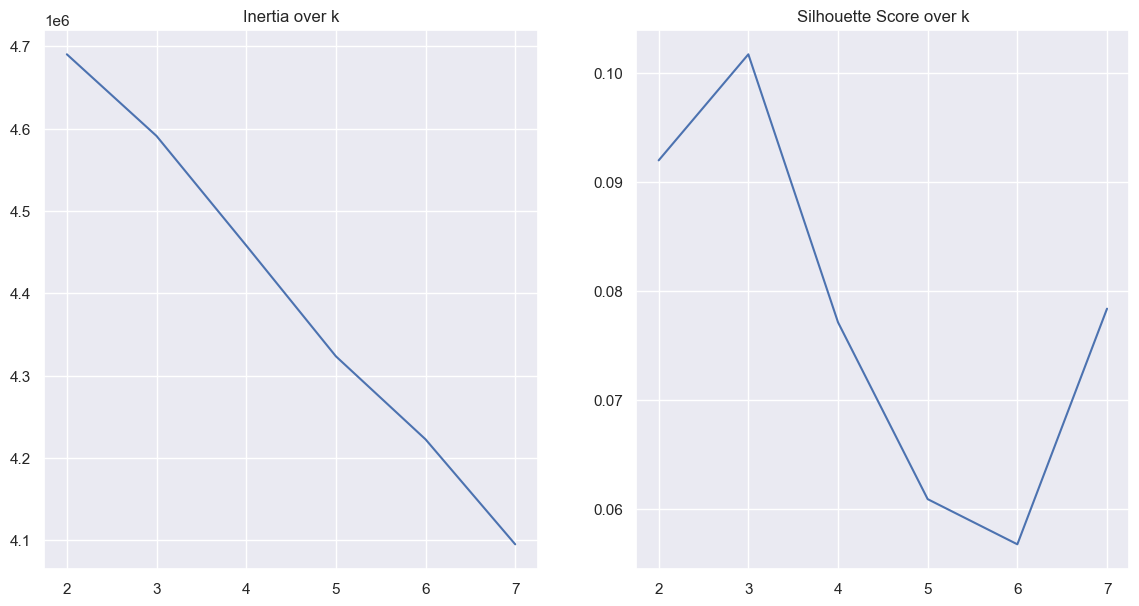

In [50]:
# visualizing metrics: elbow vs silhouette
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].plot(score_df.k, score_df.inertia)
axes[0].set_title('Inertia over k')
axes[1].plot(score_df.k, score_df.silhouette);
axes[1].set_title('Silhouette Score over k')

Silhouette score over k returns optimal k = 3
As this was done on a smaller dataset (last 100k transactions) there may be some inaccuracy. It may be also tough to predict classes which are imbalanced (ie, Executive and Multi Generation) 

K-means is preferred for unsupervised learning, since we know how many clusters (flat_type) there are. 

Assuming that the feature 'flat_type' is not available, training K-NN with supervised learning would not be possible. Its high score of 0.99 may also prove to be unreliable. 

### Rerun with k=4 on K-means on full dataset

In [80]:
# predicting Flat Type is a categorical feature
# main features that we would look at are 'town', 'floor_area_sqm', 'flat_model', 'resale_price', 'storey_ave' and 'remaining_lease'
final_df=resale_df[['flat_type', 'town', 'floor_area_sqm', 'flat_model', 'resale_price', 'storey_ave', 'remaining_lease']]
print(final_df.shape)
final_df.head()

(882951, 7)


,flat_type,town,floor_area_sqm,flat_model,resale_price,storey_ave,remaining_lease
0,3 ROOM,ANG MO KIO,73.0,NEW GENERATION,47200.0,5.0,85
1,3 ROOM,ANG MO KIO,67.0,NEW GENERATION,46000.0,2.0,86
2,3 ROOM,ANG MO KIO,67.0,NEW GENERATION,42000.0,8.0,86
3,3 ROOM,ANG MO KIO,67.0,NEW GENERATION,38000.0,11.0,86
4,3 ROOM,ANG MO KIO,67.0,NEW GENERATION,40000.0,5.0,86


In [81]:
cat_list=['town', 'flat_model']
num_list=['floor_area_sqm', 'resale_price', 'storey_ave', 'remaining_lease']

In [82]:
# get_dummies for categoric features 
final_df=pd.get_dummies(final_df, columns=cat_list, drop_first=True)

In [83]:
# X in dataframe and y in series 
X = final_df.drop(columns='flat_type')
y = final_df[['flat_type']]

In [84]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

In [85]:
km = KMeans(n_clusters=4, random_state=42)
km.fit(X_sc)

KMeans(n_clusters=4, random_state=42)

In [86]:
len(km.labels_)

882951

In [87]:
y['k_labels'] = km.labels_

/var/folders/mx/5sy10vfd4s7ct44z5lb0s3mr0000gn/T/ipykernel_2958/3194093494.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['k_labels'] = km.labels_


In [89]:
y[['flat_type','k_labels']].value_counts(normalize=True).sort_index()

flat_type         k_labels
1 ROOM            2           0.000692
2 ROOM            0           0.000010
                  1           0.001732
                  2           0.009706
                  3           0.000063
3 ROOM            0           0.019689
                  1           0.064602
                  2           0.230937
                  3           0.001621
4 ROOM            0           0.018189
                  1           0.241751
                  2           0.084364
                  3           0.036908
5 ROOM            0           0.005444
                  1           0.016547
                  2           0.016303
                  3           0.174398
EXECUTIVE         0           0.004249
                  3           0.072187
MULTI GENERATION  3           0.000608
dtype: float64

Rerunning on full dataset, input k=4, it is observed that a majority of Multi Gen, Executive and 5 room are clustered together, 4 room is one cluster and finally 1 room, 2 room and 3 room are clustered together. 

## Section 3: Policy Analysis

### Question 3C: 
The Downtown Line Stage 2 connects the Bukit Panjang heartland to the city. Have
prices increased for resale flats in the towns served by this Line? You might want to use a differencein-
differences model for this task.

A quick google search shows that Bukit Panjang is served by Bukit Panjang MRT Station, Cashew MRT Station, Hillview MRT Station. These stations are within the MRT Station coordinates extract in notebook 2. We can utilise the min_distance_to_mrt feature. 

We want to observe if the HDB resales within 1km distance to the three downtown line MRT Stations serving Bukit Panjang town have increased in resale_price after the opening of the MRT Stations on 27 December 2015. 

Caveat: There could be some resale flats under Choa Chu Kang town but within 1km of Bukit Panjang MRT Station but would not be captured by this method. Assuming that these would be insignificant. 

In [13]:
# create a column called 'filter' 
# for resale flats that are within 1km of the three MRT Stations, 'filter' = 1
resale_df['filter']=0
resale_df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,...,storey_upper,block_num,storey_ave,remaining_lease,address,latitude,longitude,min_distance_to_mrt,min_distance_to_mall,filter
0,1990-01-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976-01-01,47200.0,...,6,216,5.0,85,216 ANG MO KIO AVE 1,1.366197,103.841505,0.954205,0.804708,0
1,1990-01-01,ANG MO KIO,3 ROOM,211,ANG MO KIO AVE 3,01 TO 03,67.0,NEW GENERATION,1977-01-01,46000.0,...,3,211,2.0,86,211 ANG MO KIO AVE 3,1.369197,103.841667,0.867154,0.564789,0
2,1990-01-01,ANG MO KIO,3 ROOM,202,ANG MO KIO AVE 3,07 TO 09,67.0,NEW GENERATION,1977-01-01,42000.0,...,9,202,8.0,86,202 ANG MO KIO AVE 3,1.368458,103.844515,0.560137,0.416562,0
3,1990-01-01,ANG MO KIO,3 ROOM,235,ANG MO KIO AVE 3,10 TO 12,67.0,NEW GENERATION,1977-01-01,38000.0,...,12,235,11.0,86,235 ANG MO KIO AVE 3,1.366824,103.836491,1.471209,1.194848,0
4,1990-01-01,ANG MO KIO,3 ROOM,235,ANG MO KIO AVE 3,04 TO 06,67.0,NEW GENERATION,1977-01-01,40000.0,...,6,235,5.0,86,235 ANG MO KIO AVE 3,1.366824,103.836491,1.471209,1.194848,0


In [14]:
resale_df['town'].unique()

array(['ANG MO KIO', 'BEDOK', 'BISHAN', 'BUKIT BATOK', 'BUKIT MERAH',
       'BUKIT TIMAH', 'CENTRAL AREA', 'CHOA CHU KANG', 'CLEMENTI',
       'GEYLANG', 'HOUGANG', 'JURONG EAST', 'JURONG WEST',
       'KALLANG/WHAMPOA', 'MARINE PARADE', 'QUEENSTOWN', 'SERANGOON',
       'TAMPINES', 'TOA PAYOH', 'WOODLANDS', 'YISHUN', 'SEMBAWANG',
       'LIM CHU KANG', 'BUKIT PANJANG', 'PASIR RIS', 'SENGKANG',
       'PUNGGOL'], dtype=object)

In [15]:
resale_df.loc[(resale_df['town']== 'BUKIT PANJANG') & (resale_df['min_distance_to_mrt'] <= 1), ['filter']]=1

In [16]:
resale_df.loc[(resale_df['town']== 'BUKIT PANJANG') & (resale_df['min_distance_to_mrt'] <= 1), :].shape

(14024, 21)

In [17]:
y1=resale_df.loc[resale_df['filter']==1, 'resale_price'].tolist()

In [18]:
x1=resale_df.loc[resale_df['filter']==1, 'month'].tolist()

In [19]:
y2=resale_df.loc[(resale_df['filter']==0) & (resale_df['town']=='BUKIT PANJANG'), 'resale_price'].tolist()

In [20]:
x2=resale_df.loc[(resale_df['filter']==0) & (resale_df['town']=='BUKIT PANJANG'), 'month'].tolist()

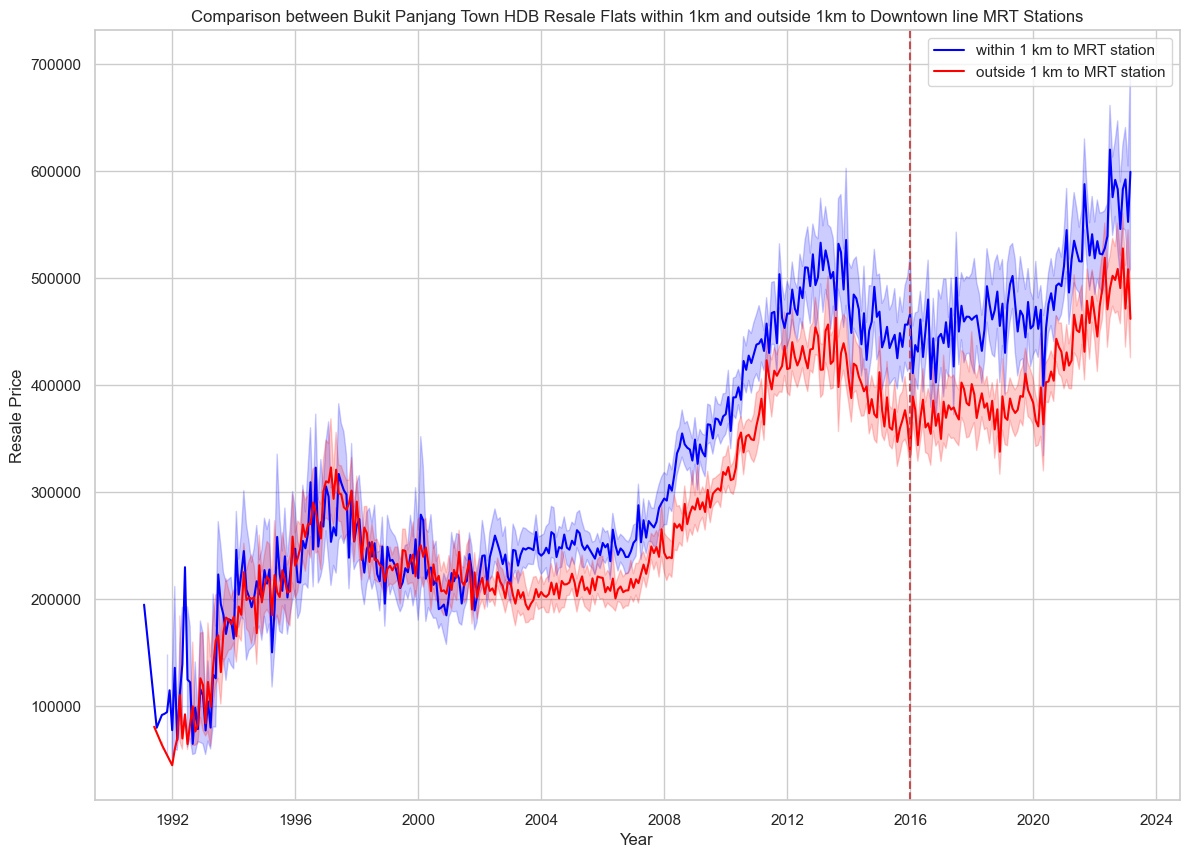

In [21]:
# set the figure size
plt.figure(figsize=(14, 10))

# Create plot
sns.set_style("whitegrid")
sns.lineplot(x=x1, y=y1, color='blue', label='within 1 km to MRT station')
sns.lineplot(x=x2, y=y2, color='red', label='outside 1 km to MRT station')

# add a vertical line at 2015-12-27
plt.axvline(pd.to_datetime('2015-12-27'), color='r', linestyle='--')

# Add labels and title
plt.xlabel("Year")
plt.ylabel("Resale Price")
plt.title("Comparison between Bukit Panjang Town HDB Resale Flats within 1km and outside 1km to Downtown line MRT Stations")

# add a legend
plt.legend()

# Show plot
plt.show()

Some observations from the initial graph plotted above
1. HDB resale prices within 1 km and outside of 1 km of MRT stations in Bukit Panjang Town started differing at around 2002
2. This difference in pricing has carried on to after the MRT stations have opened on 27 December 2015

Try with resale price per square metre 

In [22]:
resale_df['price_per_sqm']=resale_df['resale_price']/ resale_df['floor_area_sqm']
resale_df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,...,block_num,storey_ave,remaining_lease,address,latitude,longitude,min_distance_to_mrt,min_distance_to_mall,filter,price_per_sqm
0,1990-01-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976-01-01,47200.0,...,216,5.0,85,216 ANG MO KIO AVE 1,1.366197,103.841505,0.954205,0.804708,0,646.575342
1,1990-01-01,ANG MO KIO,3 ROOM,211,ANG MO KIO AVE 3,01 TO 03,67.0,NEW GENERATION,1977-01-01,46000.0,...,211,2.0,86,211 ANG MO KIO AVE 3,1.369197,103.841667,0.867154,0.564789,0,686.567164
2,1990-01-01,ANG MO KIO,3 ROOM,202,ANG MO KIO AVE 3,07 TO 09,67.0,NEW GENERATION,1977-01-01,42000.0,...,202,8.0,86,202 ANG MO KIO AVE 3,1.368458,103.844515,0.560137,0.416562,0,626.865672
3,1990-01-01,ANG MO KIO,3 ROOM,235,ANG MO KIO AVE 3,10 TO 12,67.0,NEW GENERATION,1977-01-01,38000.0,...,235,11.0,86,235 ANG MO KIO AVE 3,1.366824,103.836491,1.471209,1.194848,0,567.164179
4,1990-01-01,ANG MO KIO,3 ROOM,235,ANG MO KIO AVE 3,04 TO 06,67.0,NEW GENERATION,1977-01-01,40000.0,...,235,5.0,86,235 ANG MO KIO AVE 3,1.366824,103.836491,1.471209,1.194848,0,597.014925


In [23]:
y1=resale_df.loc[resale_df['filter']==1, 'price_per_sqm'].tolist()

In [24]:
y2=resale_df.loc[(resale_df['filter']==0) & (resale_df['town']=='BUKIT PANJANG'), 'price_per_sqm'].tolist()

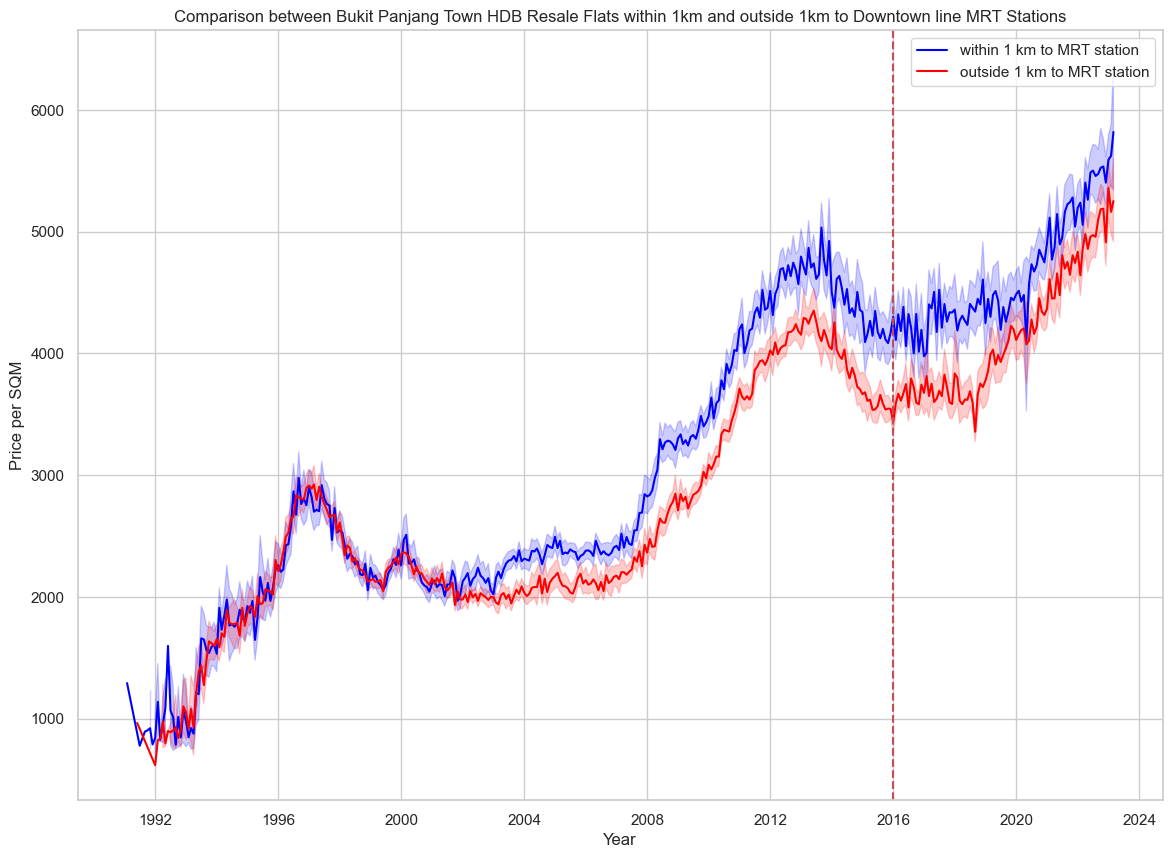

In [25]:
# set the figure size
plt.figure(figsize=(14, 10))

# Create plot
sns.set_style("whitegrid")
sns.lineplot(x=x1, y=y1, color='blue', label='within 1 km to MRT station')
sns.lineplot(x=x2, y=y2, color='red', label='outside 1 km to MRT station')

# add a vertical line at 2015-12-27
plt.axvline(pd.to_datetime('2015-12-27'), color='r', linestyle='--')

# Add labels and title
plt.xlabel("Year")
plt.ylabel("Price per SQM")
plt.title("Comparison between Bukit Panjang Town HDB Resale Flats within 1km and outside 1km to Downtown line MRT Stations")

# add a legend
plt.legend()

# Show plot
plt.show()

In [36]:
within1km_df=pd.DataFrame(resale_df.loc[resale_df['filter']==1, 'price_per_sqm'].groupby(resale_df['month']).mean() )
within1km_df

,price_per_sqm
month,
1991-02-01,1291.390728
1991-07-01,776.699029
1991-09-01,893.203883
1991-10-01,902.912621
1991-11-01,920.509548
...,...
2022-11-01,5536.027009
2022-12-01,5403.420522
2023-01-01,5591.547823


In [37]:
outside1km_df=pd.DataFrame(resale_df.loc[(resale_df['filter']==0) & (resale_df['town']=='BUKIT PANJANG'), 'price_per_sqm'].groupby(resale_df['month']).mean() )
outside1km_df

,price_per_sqm
month,
1991-06-01,964.285714
1991-09-01,815.720809
1992-01-01,616.438356
1992-02-01,821.917808
1992-03-01,833.333333
...,...
2022-11-01,5189.248988
2022-12-01,4912.765152
2023-01-01,5358.970343


In [40]:
# not all the months have a transaction for within 1km and outside 1km resale units
# merge base on left join to keep months where there are transactions within 1km units to find the difference in pricing 

difference_df=within1km_df.merge(outside1km_df, how='inner', on='month')
difference_df

,price_per_sqm_x,price_per_sqm_y
month,,
1991-09-01,893.203883,815.720809
1992-01-01,841.311198,616.438356
1992-02-01,1136.986301,821.917808
1992-03-01,824.932393,833.333333
1992-04-01,953.609555,976.799480
...,...,...
2022-11-01,5536.027009,5189.248988
2022-12-01,5403.420522,4912.765152
2023-01-01,5591.547823,5358.970343


In [42]:
difference_df['difference']=difference_df['price_per_sqm_x'] - difference_df['price_per_sqm_y']
difference_df

,price_per_sqm_x,price_per_sqm_y,difference
month,,,
1991-09-01,893.203883,815.720809,77.483075
1992-01-01,841.311198,616.438356,224.872842
1992-02-01,1136.986301,821.917808,315.068493
1992-03-01,824.932393,833.333333,-8.400940
1992-04-01,953.609555,976.799480,-23.189925
...,...,...,...
2022-11-01,5536.027009,5189.248988,346.778020
2022-12-01,5403.420522,4912.765152,490.655370
2023-01-01,5591.547823,5358.970343,232.577480


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


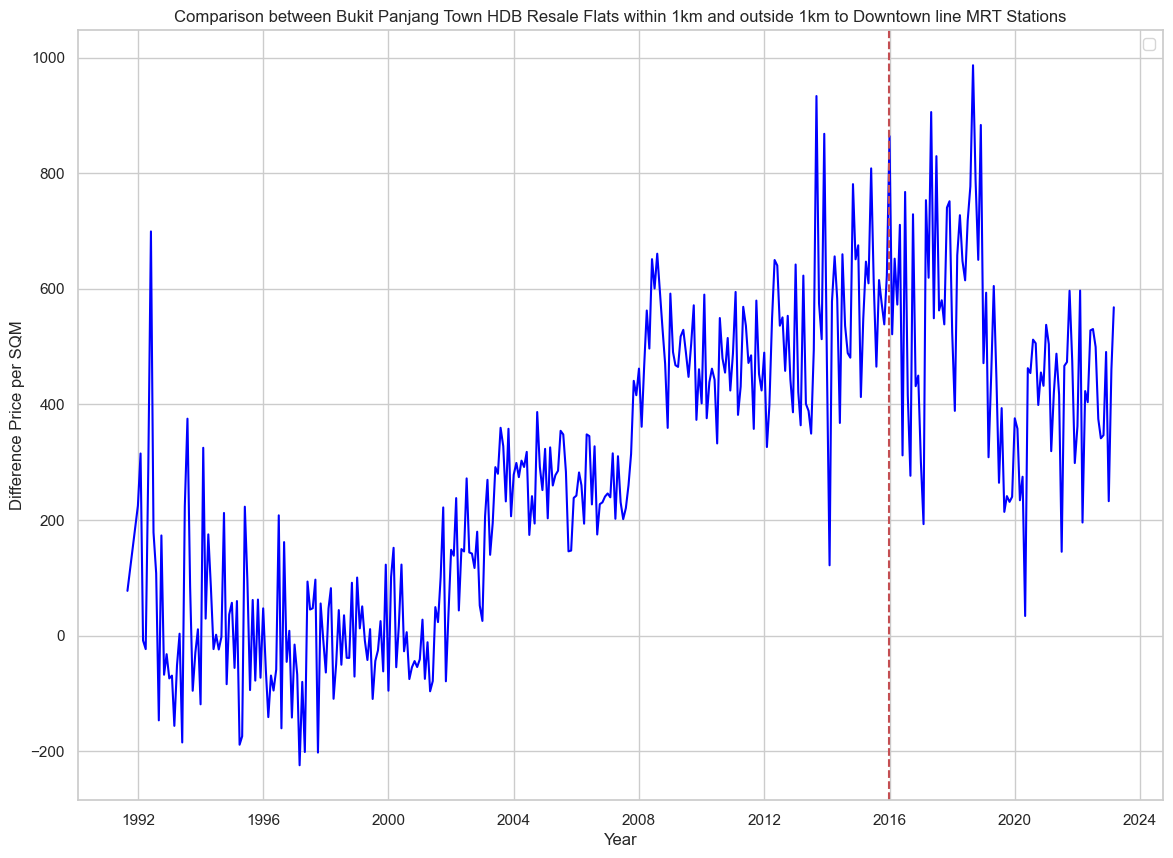

In [44]:
# set the figure size
plt.figure(figsize=(14, 10))

# Create plot
sns.set_style("whitegrid")
sns.lineplot(data=difference_df, x='month' , y='difference', color='blue')

# add a vertical line at 2015-12-27
plt.axvline(pd.to_datetime('2015-12-27'), color='r', linestyle='--')

# Add labels and title
plt.xlabel("Year")
plt.ylabel("Difference Price per SQM")
plt.title("Comparison between Bukit Panjang Town HDB Resale Flats within 1km and outside 1km to Downtown line MRT Stations")

# add a legend
plt.legend()

# Show plot
plt.show()

In [46]:
difference_df.tail(50)

,price_per_sqm_x,price_per_sqm_y,difference
month,,,
2019-02-01,4448.097242,3854.905551,593.191692
2019-03-01,4300.632038,3992.036659,308.595379
2019-04-01,4481.893437,4031.144404,450.749033
2019-05-01,4512.760157,3907.985663,604.774494
2019-06-01,4432.451147,3987.423298,445.027848
2019-07-01,4194.312503,3929.878015,264.434487
2019-08-01,4380.925927,3987.374041,393.551886
2019-09-01,4260.959676,4046.844811,214.114865
2019-10-01,4347.444500,4106.108237,241.336262
